# Modeling

### Import Relevant Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, snowball
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.util import ngrams

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read in Processed Data

In [2]:
df = pd.read_parquet('./Data/processed_reports.parquet')

In [3]:
df.reset_index(inplace=True)

In [4]:
df.drop(['index'],axis=1,inplace=True)

### Create secondary classification target 

In [5]:
df['target'] = df.Round

In [6]:
df.target[df.target >= 6] = 0

In [7]:
df.target[df.target == 1] = 10

In [8]:
df.target[(df.target == 4) | (df.target == 5)] = 1

In [9]:
df.target[df.target == 3] = 2

In [10]:
df.target[df.target == 10] = 3

In [11]:
cleaned_df = df.drop(['report','processed_report','joined_report','weight_y','height_y'],axis=1) 

In [12]:
# Add _col to each column to prevent duplicate naming when combining with the scouting report words
cleaned_df = cleaned_df.add_suffix('_col')

In [13]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,38.5,17.0,4.0,2.0,9.0,Sun Belt Conference,105.744617,144.109521,137.671457,LB
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,NaN,NaN,NaN,P
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,11.5,0.5,6.0,NaN,NaN,Big Ten Conference,88.494256,NaN,NaN,LB
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,80.603451,NaN,NaN,OL


### Add grades and rankings for 2022 draft

In [14]:
grades22 = pd.read_excel('./Data/addgrades.xlsx')

In [15]:
cleaned_df.pos_rk_col[cleaned_df.year_col == 2022] = grades22.pos_rk_col
cleaned_df.ovr_rk_col[cleaned_df.year_col == 2022] = grades22.ovr_rk_col
cleaned_df.grade_col[cleaned_df.year_col == 2022] = grades22.grade_col

C:\Users\capta\AppData\Local\Temp\ipykernel_20376\2333570552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.pos_rk_col[cleaned_df.year_col == 2022] = grades22.pos_rk_col
C:\Users\capta\AppData\Local\Temp\ipykernel_20376\2333570552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.ovr_rk_col[cleaned_df.year_col == 2022] = grades22.ovr_rk_col
C:\Users\capta\AppData\Local\Temp\ipykernel_20376\2333570552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [16]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,18.0,198.0,55.0,23.0,7,252,...,38.5,17.0,4.0,2.0,9.0,Sun Belt Conference,105.744617,144.109521,137.671457,LB
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,NaN,NaN,NaN,P
4206,Jesse Luketa,2022.0,NaN,NaN,11.0,167.0,59.0,23.0,7,256,...,11.5,0.5,6.0,NaN,NaN,Big Ten Conference,88.494256,NaN,NaN,LB
4207,Marquis Hayes,2022.0,NaN,NaN,10.0,139.0,64.0,23.0,7,257,...,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,80.603451,NaN,NaN,OL


### TFIDF Vectorizing

In [17]:
tf = TfidfVectorizer(ngram_range=(1,3),min_df=.062,max_df =.75)

In [18]:
X = tf.fit_transform(df.joined_report)

In [19]:
report_df = pd.DataFrame(X.toarray(),columns=tf.get_feature_names())

In [20]:
report_df.columns

Index(['2002', '2003', '2004', '2005', '2006', '2016', 'abil', 'adequ', 'also',
       'appear',
       ...
       'two season', 'upsid', 'valu', 'versatil', 'well', 'work', 'yard',
       'year', 'year starter', 'zone'],
      dtype='object', length=198)

### Merge TFIDF features with all other features

In [21]:
model_df = pd.concat([cleaned_df,report_df],axis=1)

In [22]:
model_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,two season,upsid,valu,versatil,well,work,yard,year,year starter,zone
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.302746,0.197995,0.0,0.000000
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,0.0,0.0,0.0,0.128312,0.0,0.130273,0.338669,0.000000,0.0,0.000000
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.261304,0.113928,0.0,0.000000
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200609,0.000000,0.0,0.000000
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.282241,0.061528,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,18.0,198.0,55.0,23.0,7,252,...,0.0,0.0,0.0,0.199357,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.370394,0.000000,0.0,0.000000
4206,Jesse Luketa,2022.0,NaN,NaN,11.0,167.0,59.0,23.0,7,256,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4207,Marquis Hayes,2022.0,NaN,NaN,10.0,139.0,64.0,23.0,7,257,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.237427


### Linear Regression

In [23]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('lin',LinearRegression())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
}

# GridSearch with Cross Validation of 5
lin = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [24]:
# Fit GridSearch
lin.fit(X_train,y_train)

# Get y_pred
y_pred_lin = lin.predict(X_test)

# Print results
print(r2_score(y_test,y_pred_lin),mean_squared_error(y_test,y_pred_lin));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.536091448465273 2302.8036193818957


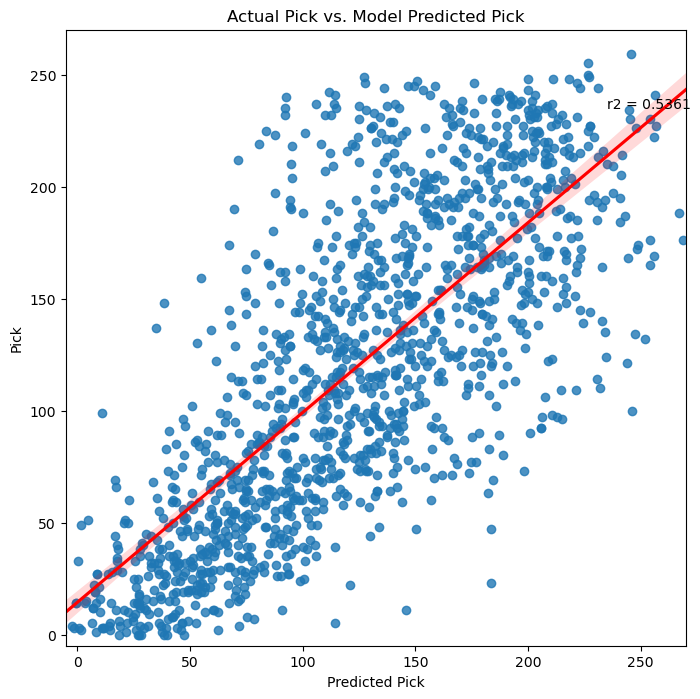

In [25]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_lin,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(-5,270)
plt.ylim(-5,270)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_lin),4)}',xy=(235,235));

### Random Forest

In [81]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
rfc_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

# Fit model
rfc_pipe.fit(X_train, y_train)

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[102],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'forest__max_depth':[24],
    'forest__min_samples_split':[2],
    'forest__min_samples_leaf':[6]
}

# GridSearch with Cross Validation of 5
forest = GridSearchCV(estimator=rfc_pipe,
                          param_grid=grid,
                          cv=5)

In [80]:
forest.best_params_

{'forest__max_depth': 24,
 'forest__min_samples_leaf': 6,
 'forest__min_samples_split': 2,
 'forest__n_estimators': 102,
 'sample': RandomOverSampler(random_state=42)}

In [82]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
forest.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_forest = forest.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_forest),mean_squared_error(y_test,y_pred_forest));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\capta\anaconda3\li

18.478988468647003 minutes
0.6747055840559547 1614.7345331800645


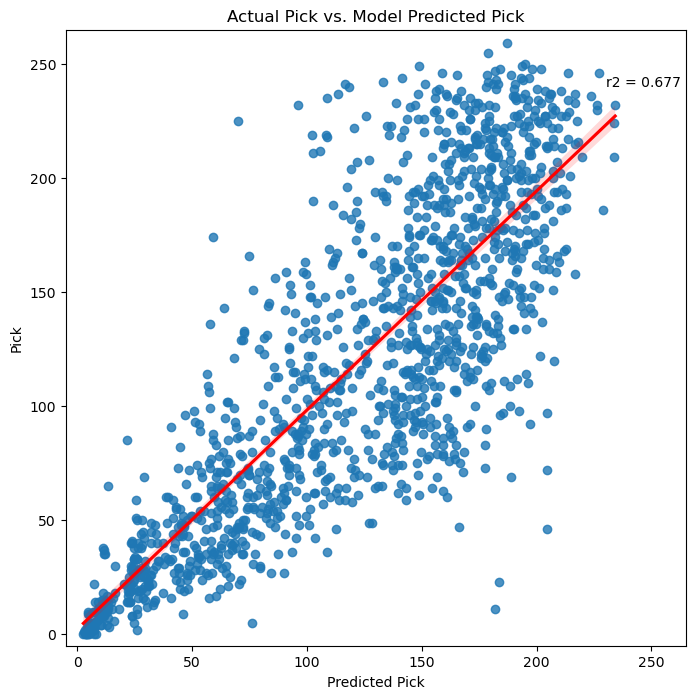

In [28]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_forest,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(-5,265)
plt.ylim(-5,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_forest),3)}',xy=(230,240));

### Get Weights from Random Forest Model

In [29]:
# Get names of the OneHotEncoded Columns
rfc_pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

array(['x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelv

In [30]:
# Get all the other X_train columns
X_train.columns.to_list()

['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col'

In [31]:
# Combine the X_train columns and the OneHotEncoded problems in the proper order
# EXTREMELY important as otherwise the feature names will be mismatched
feature_cols = ['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col',
 'rec_yds_season_col',
 'rec_yds_per_rec_season_col',
 'scrim_att_season_col',
 'scrim_yds_season_col',
 'scrim_yds_per_att_season_col',
 'scrim_td_season_col',
 'rush_att_career_col',
 'rush_yds_career_col',
 'rush_yds_per_att_career_col',
 'rush_td_career_col',
 'rec_career_col',
 'rec_yds_career_col',
 'rec_yds_per_rec_career_col',
 'rec_td_career_col',
 'scrim_att_career_col',
 'scrim_yds_career_col',
 'scrim_yds_per_att_career_col',
 'scrim_td_career_col',
 'fumbles_rec_yds_career_col',
 'fumbles_rec_td_career_col',
 'rec_td_season_col',
 'def_int_td_season_col',
 'def_int_td_career_col',
 'fumbles_rec_career_col',
 'fumbles_rec_yds_season_col',
 'fumbles_rec_td_season_col',
 'fumbles_rec_season_col',
 'tackles_solo_season_col',
 'tackles_assists_season_col',
 'tackles_total_season_col',
 'tackles_loss_season_col',
 'sacks_season_col',
 'pass_defended_season_col',
 'tackles_solo_career_col',
 'tackles_assists_career_col',
 'tackles_total_career_col',
 'tackles_loss_career_col',
 'sacks_career_col',
 'pass_defended_career_col',
 'fumbles_forced_season_col',
 'fumbles_forced_career_col',
 'x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       'x0_Pioneer Football League', 'x0_South Atlantic Conference',
       'x0_Southeastern Conference', 'x0_Southern Conference',
       'x0_Southern Intercollegiate Athletic Conference',
       'x0_Southland Conference', 'x0_Southwestern Athletic Conference',
       'x0_Sun Belt Conference', 'x0_Western Athletic Conference',
       'x0_Wisconsin Intercollegiate Athletic Conference','x0_None','speed_col',
 'shuttle_agility_col',
 'cone_agility_col','x1_DB', 'x1_DE', 'x1_DL', 'x1_DT', 'x1_FB', 'x1_K', 'x1_LB',
       'x1_LS', 'x1_OL', 'x1_P', 'x1_QB', 'x1_RB', 'x1_S', 'x1_TE',
       'x1_WR','2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2016',
 'abil',
 'adequ',
 'also',
 'appear',
 'arm',
 'athlet',
 'athlet abil',
 'athletic',
 'averag',
 'back',
 'backup',
 'ball',
 'ball skill',
 'best',
 'better',
 'big',
 'block',
 'blocker',
 'bodi',
 'burst',
 'career',
 'catch',
 'class',
 'close',
 'colleg',
 'combin',
 'come',
 'concern',
 'consist',
 'contribut',
 'corner',
 'could',
 'coverag',
 'day',
 'defend',
 'defens',
 'develop',
 'draft',
 'durabl',
 'earli',
 'edg',
 'effect',
 'eight',
 'elit',
 'end',
 'end speed',
 'enough',
 'excel',
 'experi',
 'explos',
 'field',
 'final',
 'finish',
 'first',
 'fit',
 'five',
 'flash',
 'flash abil',
 'footbal',
 'forc',
 'four',
 'frame',
 'freshman',
 'fumbl',
 'game',
 'get',
 'good',
 'grade',
 'great',
 'guard',
 'hand',
 'high',
 'howev',
 'ideal',
 'improv',
 'inconsist',
 'injuri',
 'insid',
 'instinct',
 'intercept',
 'job',
 'junior',
 'lack',
 'lack ideal',
 'last',
 'late',
 'left',
 'length',
 'level',
 'like',
 'limit',
 'line',
 'lineback',
 'long',
 'loss',
 'lot',
 'make',
 'man',
 'miss',
 'move',
 'much',
 'natur',
 'need',
 'nfl',
 'offens',
 'one',
 'outsid',
 'outstand',
 'overal',
 'pass',
 'pass rusher',
 'physic',
 'pick',
 'play',
 'play game',
 'player',
 'point',
 'posit',
 'possess',
 'potenti',
 'power',
 'pro',
 'product',
 'project',
 'prospect',
 'quarterback',
 'quick',
 'rang',
 'receiv',
 'record',
 'redshirt',
 'return',
 'right',
 'round',
 'round pick',
 'rout',
 'rout runner',
 'run',
 'run defend',
 'runner',
 'rush',
 'rusher',
 'sack',
 'safeti',
 'scheme',
 'season',
 'second',
 'senior',
 'set',
 'short',
 'show',
 'six',
 'size',
 'skill',
 'special',
 'special team',
 'speed',
 'start',
 'start game',
 'starter',
 'still',
 'strength',
 'strong',
 'tackl',
 'tackl loss',
 'take',
 'team',
 'techniqu',
 'term',
 'three',
 'three season',
 'tight',
 'time',
 'top',
 'top end',
 'top end speed',
 'total',
 'touchdown',
 'tough',
 'true',
 'true freshman',
 'two',
 'two season',
 'upsid',
 'valu',
 'versatil',
 'well',
 'work',
 'yard',
 'year',
 'year starter',
 'zone']

In [32]:
# Get the weight values of the Random Forest Model
weights = rfc_pipe[-1].feature_importances_

In [33]:
# Zip the names and the weights together into a DataFrame
coefs = pd.DataFrame(zip(feature_cols,weights))

### Sorted Results of the Weights of the Random Forest Model

In [34]:
coefs.sort_values(by=1,ascending=False).head(20)

,0,1
3,ovr_rk_col,0.589220
4,grade_col,0.111697
2,pos_rk_col,0.010038
6,reportlen_col,0.007655
84,x0_Atlantic Coast Conference,0.005594
7,forty_yd_col,0.005448
0,weight_x_col,0.004776
1,height_x_col,0.004475
86,x0_Big Sky Conference,0.004071
85,x0_Big East,0.003748


### KNN

In [35]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('knn',KNeighborsRegressor())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'knn__n_neighbors':[30,40]
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'forest__max_depth':[4,12,None],
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
knn = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [36]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
knn.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_knn = knn.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_knn),mean_squared_error(y_test,y_pred_knn));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\

0.09431142409642537 minutes
0.22207632267830546 3861.548690604752


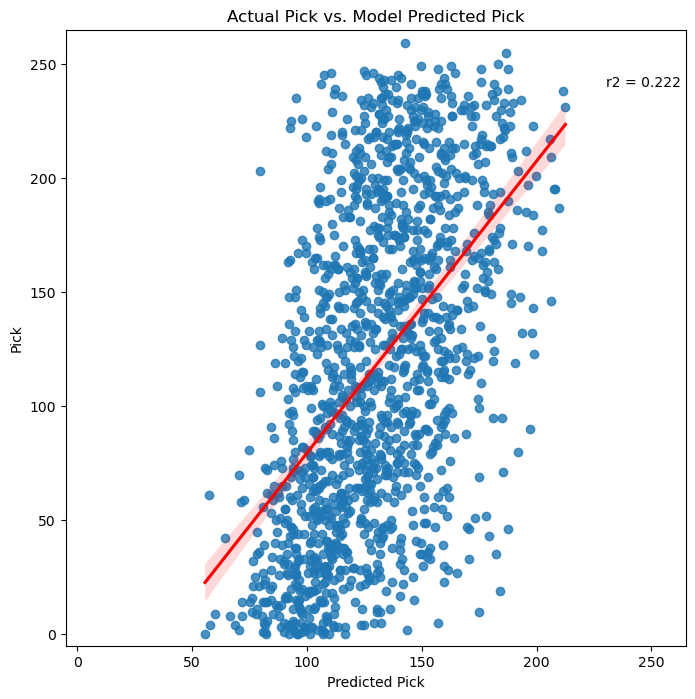

In [37]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_knn,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(-5,265)
plt.ylim(-5,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_knn),3)}',xy=(230,240));

### Decision Tree

In [38]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('tree',DecisionTreeRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)]
#     'tree__n_estimators':[75,100,125],
#     'tree__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'tree__max_depth':[4,12,None],
#     'tree__min_samples_split':[1,2,3],
#     'tree__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
tree = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [39]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
tree.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_tree = tree.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_tree),mean_squared_error(y_test,y_pred_tree));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.12241146564483643 minutes
0.33069881208260077 3322.3556515478763


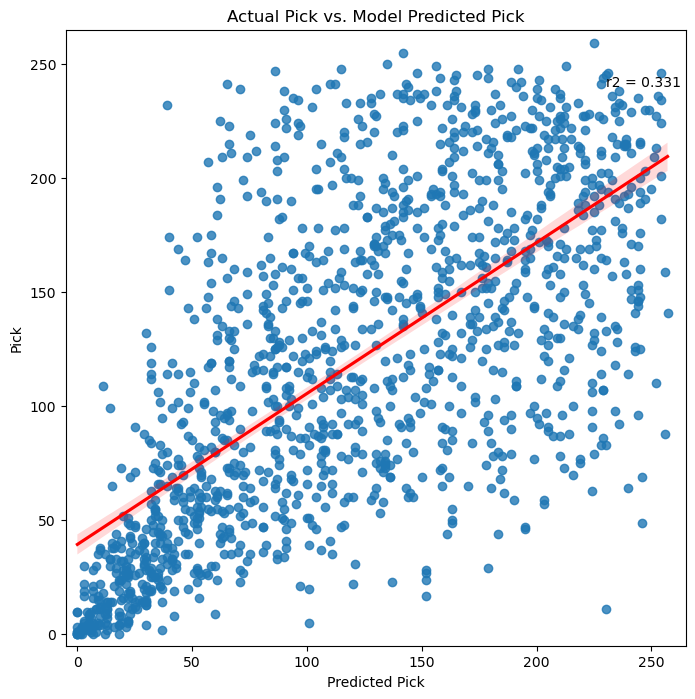

In [40]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_tree,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(-5,265)
plt.ylim(-5,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_tree),3)}',xy=(230,240));

### XGBoost

In [41]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('xgb',XGBRegressor())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'xgb__max_depth':[2,1],
    'xgb__eta':[.2,.22],
    'xgb__gamma':[0,.15]
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
xgb = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [42]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
xgb.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_xgb = xgb.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_xgb),mean_squared_error(y_test,y_pred_xgb));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta

1.0147798180580139 minutes
0.6709735368605907 1633.260106293034


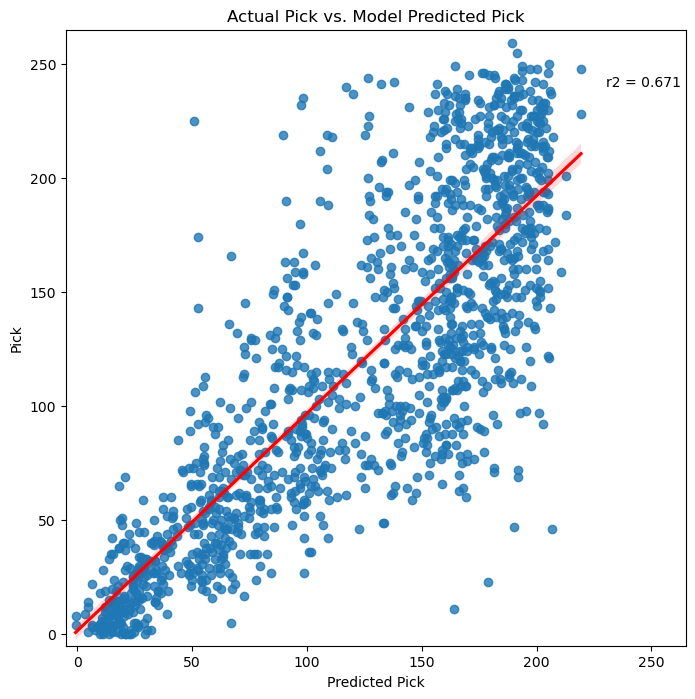

In [43]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_xgb,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(-5,265)
plt.ylim(-5,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_xgb),3)}',xy=(230,240));

### ADABoost

In [44]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('ada',AdaBoostRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'ada__n_estimators':[42,40],
    'ada__learning_rate':[.35],
    'ada__loss':['linear','square','exponential']
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
ada = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [45]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
ada.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_ada = ada.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_ada),mean_squared_error(y_test,y_pred_ada));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta

3.458640507857005 minutes
0.6586056976639032 1694.653035506871


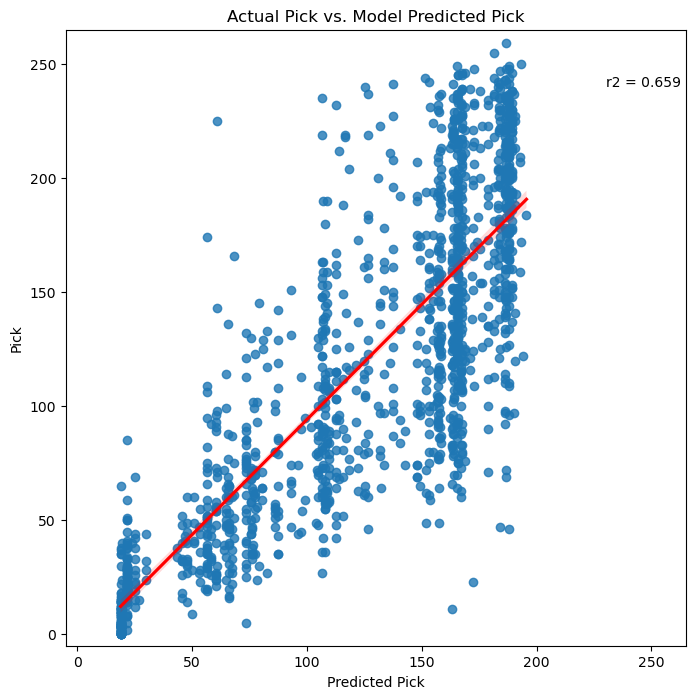

In [46]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_ada,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(-5,265)
plt.ylim(-5,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_ada),3)}',xy=(230,240));

### GradientBoost

In [83]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('grad',GradientBoostingRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'grad__n_estimators':[93,94,95],
    'grad__learning_rate':[.05,.06,.04],
#     'grad__loss':['absolute_error','squared_error','huber','quantile'],
    'grad__min_samples_split':[1,2,3],
    'grad__min_samples_leaf':[1,2],
    'grad__max_depth':[3,4,5],
    'grad__min_impurity_decrease':[.3,.31,.32]
}

# GridSearch with Cross Validation of 5
grad = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [ ]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
grad.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_grad = grad.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_grad),mean_squared_error(y_test,y_pred_grad));

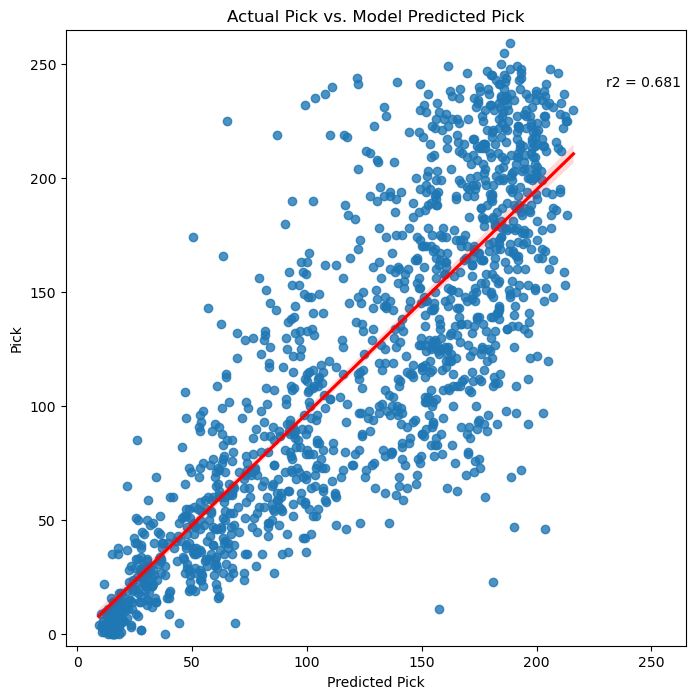

In [49]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_grad,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(-5,265)
plt.ylim(-5,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_grad),3)}',xy=(230,240));

### Analyze Results of Top Random Forest Model

In [50]:
# Create DataFrame of X_test, y_test, y_preds
results = pd.concat([player_name.reset_index(),player_round.reset_index(),player_year.reset_index(),X_test.reset_index(),pd.Series(y_pred_forest),pd.Series(y_test)],axis=1)

In [51]:
results

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,valu,versatil,well,work,yard,year,year starter,zone,0,1
0,1073,DeAndre Wright,1073,6,1073,2009.0,1073,198.0,70.750,41.0,...,0.00000,0.000000,0.287967,0.000000,0.000000,0.000000,0.000000,0.0,193.046342,199
1,144,Adrian McPherson,144,5,144,2005.0,144,218.0,75.500,9.0,...,0.00000,0.000000,0.098724,0.000000,0.000000,0.083411,0.000000,0.0,118.973855,151
2,2380,Jon Feliciano,2380,4,2380,2015.0,2380,323.0,75.875,17.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,184.636323,127
3,184,DeAndra Cobb,184,6,184,2005.0,184,196.0,69.750,24.0,...,0.00000,0.082646,0.000000,0.000000,0.218138,0.063405,0.000000,0.0,199.438488,200
4,2587,Kyler Fackrell,2587,3,2587,2016.0,2587,245.0,77.000,10.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,140.935908,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,2282,Phillip Dorsett,2282,1,2282,2015.0,2282,185.0,69.750,6.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,23.158646,28
1385,2986,Treyvon Hester,2986,7,2986,2017.0,2986,300.0,74.375,20.0,...,0.19871,0.000000,0.000000,0.165464,0.000000,0.250062,0.179509,0.0,182.513322,243
1386,1078,Ra'Shon Harris,1078,6,1078,2009.0,1078,298.0,75.750,24.0,...,0.00000,0.000000,0.000000,0.404393,0.000000,0.000000,0.000000,0.0,171.362768,204
1387,1413,Martez Wilson,1413,3,1413,2011.0,1413,250.0,76.000,4.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,65.247754,71


### Create difference columns between actual pick number and modeled pick projection

In [52]:
# Add 1 to the 1 column since it has a 0 and I want the actual pick number
results['difference'] = results[0] - (results[1] + 1)
results['abs_difference'] = (results[0] - (results[1]+1)).abs()

In [53]:
# Average each pick is off by
results.abs_difference.mean()

30.36774289205768

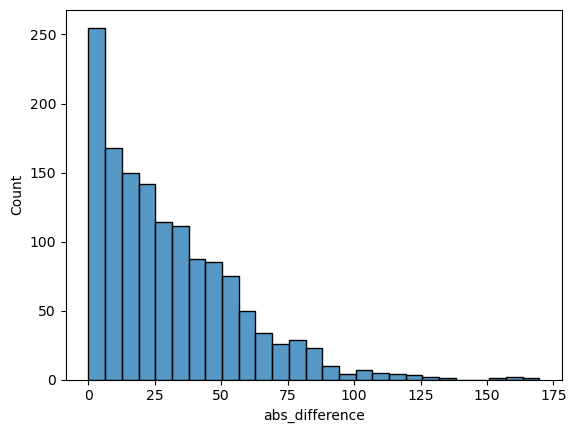

In [54]:
sns.histplot(results.abs_difference);

### Create DataFrame of the best results where the pick was projected within 16 picks

In [55]:
best = results[results.abs_difference <= 16]

In [56]:
best

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,well,work,yard,year,year starter,zone,0,1,difference,abs_difference
0,1073,DeAndre Wright,1073,6,1073,2009.0,1073,198.0,70.750,41.0,...,0.287967,0.0,0.000000,0.000000,0.0,0.0,193.046342,199,-6.953658,6.953658
3,184,DeAndra Cobb,184,6,184,2005.0,184,196.0,69.750,24.0,...,0.000000,0.0,0.218138,0.063405,0.0,0.0,199.438488,200,-1.561512,1.561512
5,2768,Charles Harris,2768,1,2768,2017.0,2768,253.0,74.750,1.0,...,0.000000,0.0,0.000000,0.273181,0.0,0.0,30.930259,21,8.930259,8.930259
9,2862,Mack Hollins,2862,4,2862,2017.0,2862,221.0,76.000,10.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,107.113804,117,-10.886196,10.886196
11,3290,Irv Smith Jr.,3290,2,3290,2019.0,3290,242.0,74.375,3.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,39.172518,49,-10.827482,10.827482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,3053,D.J. Chark,3053,2,3053,2018.0,3053,199.0,74.875,6.0,...,0.000000,0.0,0.422382,0.000000,0.0,0.0,51.372794,60,-9.627206,9.627206
1379,2042,Brandin Cooks,2042,1,2042,2014.0,2042,189.0,69.750,4.0,...,0.398851,0.0,0.000000,0.000000,0.0,0.0,21.865834,19,1.865834,1.865834
1380,1632,Casey Hayward,1632,2,1632,2012.0,1632,192.0,71.375,8.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,66.977907,61,4.977907,4.977907
1384,2282,Phillip Dorsett,2282,1,2282,2015.0,2282,185.0,69.750,6.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,23.158646,28,-5.841354,5.841354


### Create DataFrame of the worst results where the pick was projected more than 64 picks away

In [57]:
worst = results[results.abs_difference >= 64]

### Normalized counts of players that were the best and worst by round

In [58]:
best.Round_col.value_counts(normalize=True)

1    0.281437
6    0.163673
2    0.151697
5    0.141717
3    0.127745
4    0.101796
7    0.031936
Name: Round_col, dtype: Float64

In [59]:
worst.Round_col.value_counts(normalize=True)

7    0.342282
3    0.322148
6    0.114094
4    0.080537
2    0.067114
5    0.053691
1    0.020134
Name: Round_col, dtype: Float64

The Model was best at predicting players in round 1 and was worst at projecting players in round 7

### Position Breakdown of the model's best and worst projections

In [60]:
# Count of the normalized best position minus the actual position breakdown
best_pos = best.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

# Count of the normalized worst position minus the actual position breakdown
worst_pos = worst.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

In [61]:
best_pos.sort_values(ascending=False)

DE    0.017955
WR    0.016938
TE    0.007488
OL    0.006919
DT    0.004703
LS    0.001832
P     0.001505
RB    0.000711
K    -0.000491
DL   -0.005203
CB   -0.005992
QB   -0.006091
DB   -0.009631
LB   -0.010778
S    -0.018425
FB         NaN
Name: pos_col, dtype: float64

In [62]:
worst_pos.sort_values(ascending=False)

OL    0.034060
DB    0.024797
S     0.014582
K     0.013655
QB    0.013118
DT    0.006847
CB    0.003063
P     0.000232
DL   -0.000488
WR   -0.011408
TE   -0.016839
RB   -0.019999
LB   -0.023879
DE   -0.034142
FB         NaN
LS         NaN
Name: pos_col, dtype: float64

The model was best at predicting WR and DEs while it struggled with OL, S, CB, and DB. 3 of the 4 worst positions were all the secondary positions.

In [63]:
# Breakdown of the positions that were the best in the first round
best.pos_col[best.Round_col == 1].value_counts(normalize=True) - results.pos_col[results.Round_col == 1].value_counts(normalize=True)

CB   -0.001972
DB   -0.003831
DE    0.009899
DL   -0.003603
DT    0.001289
LB    0.015474
OL   -0.020784
QB   -0.005916
RB    0.012098
S          NaN
TE   -0.000114
WR    0.018849
Name: pos_col, dtype: float64

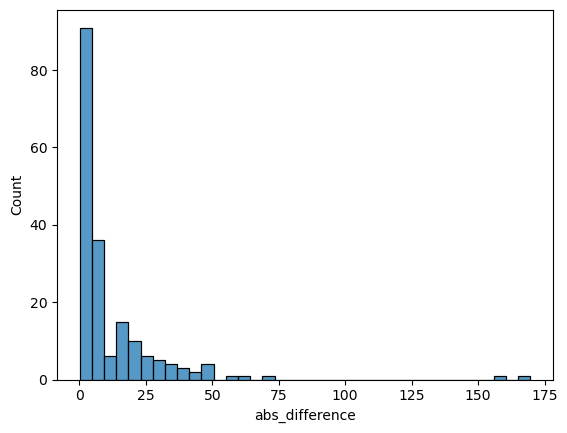

In [64]:
sns.histplot(results[results.Round_col == 1].abs_difference);

### Checking how the word develop appears in round 1 and when the difference is greater than 32

In [65]:
one_round = results[results.Round_col == 1]

In [66]:
one_round.develop

5       0.000000
21      0.000000
25      0.065799
31      0.155973
34      0.000000
          ...   
1349    0.000000
1371    0.000000
1373    0.000000
1379    0.000000
1384    0.000000
Name: develop, Length: 187, dtype: float64

In [67]:
miss_one = one_round[one_round.abs_difference > 32]

In [68]:
miss_one.develop.mean()

0.0404603743194328

In [69]:
one_round.develop.mean()

0.030089307317340747

### Average Differences by Round

In [70]:
results[results.Round_col == 1].abs_difference.mean()

12.188370338420931

In [71]:
results[results.Round_col == 2].abs_difference.mean()

24.192818635134746

In [72]:
results[results.Round_col == 3].abs_difference.mean()

37.956554007994804

In [73]:
results[results.Round_col == 4].abs_difference.mean()

32.94870653081675

In [74]:
results[results.Round_col == 5].abs_difference.mean()

26.366964001566885

In [75]:
results[results.Round_col == 6].abs_difference.mean()

27.461440565060293

In [76]:
results[results.Round_col == 7].abs_difference.mean()

51.4301081652603

### Breakdown of features by Pos

In [77]:
cleaned_df[cleaned_df.Round_col == 1].groupby('pos_col').mean().sort_values(by='ovr_rk_col')

,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,target_col,...,tackles_assists_career_col,tackles_total_career_col,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,speed_col,shuttle_agility_col,cone_agility_col
pos_col,,,,,,,,,,,,,,,,,,,,,
TE,2012.875000,251.062500,76.695312,1.312500,17.062500,91.625000,22.125000,1.0,20.3125,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.666030,144.407558,145.712496
DT,2013.204082,308.595745,75.111702,2.714286,17.489796,91.795918,22.083333,1.0,17.081633,3.0,...,54.066667,114.133333,22.888889,9.444444,4.388889,1.736842,2.379310,97.849975,136.961771,143.358176
DE,2012.900000,270.151515,76.119318,2.914286,17.871429,91.814286,22.014493,1.0,15.742857,3.0,...,49.812500,118.468750,32.085938,18.460938,5.000000,2.500000,3.877193,109.577507,148.839163,146.681849
QB,2013.962264,226.826923,75.509615,2.471698,18.264151,91.452830,22.134615,1.0,9.90566,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.558852,137.959072,133.613383
RB,2011.444444,217.138889,70.961806,2.111111,18.833333,92.083333,21.735294,1.0,17.138889,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.335770,132.875457,127.253084
WR,2014.043478,205.095238,73.043651,3.362319,20.057971,90.869565,21.692308,1.0,17.347826,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.740370,129.574828,123.432178
LB,2013.868852,244.793103,74.413793,2.344262,21.344262,90.590164,21.983333,1.0,16.836066,3.0,...,83.962963,196.481481,27.861111,12.000000,6.063830,2.451613,4.125000,110.896430,156.247868,141.032109
DB,2010.619048,199.245902,70.651639,2.741935,22.225806,91.387097,22.129032,1.0,18.936508,3.0,...,49.471698,159.037736,8.650943,2.208333,15.086957,1.444444,2.047619,103.610605,140.182586,126.084150
OL,2014.135922,313.936170,77.140957,2.553398,23.339806,90.126214,22.274510,1.0,16.834951,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.208684,133.981217,138.969886
